In [1]:
from gym import Env, spaces
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import copy
import torch
import math
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL

vehicle_SIZE = (25,25)
vehicle_SPEED = (30,40) #m/s
RSU_SIZE = (32,32)
CDC_SIZE = (48,48)
base_x = 0
base_y = 0
content_NUM = 2000

class Edge_Caching_Vehicular_Networks(Env):
    def __init__(self):
        super(Edge_Caching_Vehicular_Networks,self).__init__()

        # canvas settings
        self.canvas_SHAPE = (700,1500,3,)  # for view
        self.x_MIN = 0
        self.x_MAX = self.canvas_SHAPE[1] - vehicle_SIZE[0]
        self.show = False

        # RL settings
        self.observation_SHAPE = (content_NUM * 2,)
        self.observation_space = spaces.MultiBinary(self.observation_SHAPE)
        self.action_shape = (content_NUM,)
        self.action_space = spaces.MultiBinary(self.action_shape)
        self.algorithm = 'LFU'
        self.hit_ratio = 0
        self.hit_ratio_LST = []

        # content settings
        self.content_NUM = content_NUM     #
        self.content_SIZE = (0,2)   # MB
        self.content = []

        # vehicle
        self.vehicle_LST = []
        self.vehicle_MAXNUM = 60    # traffic density
        self.vehicle_request_color = (1, 0, 0)
        self.vehicle_request_thick = 1
        self.vehicle_size = (25,25)
        self.vehicle_speed = (30,40)

        # RSU
        self.RSU_LST = []
        self.RSU_NUM = 1
        self.RSU_STORIGE = 200.0  # MB
        # self.RSU_INTERVAL = 10.0  # km
        # self.RSU_RADIUS = 5.0     # km
        # self.RSU_BANDWIDTH = 20   # MHz
        self.RSU_path = '/content/drive/MyDrive/fig/RSU.png'
        self.RSU_size = (32, 32)
        self.RSU_forward_color = (0.5,0.5,0.5)
        self.RSU_transfer_color = (1,0,0)
        self.RSU_upload_color = (0.1,0.1,0.6)
        self.RSU_send_color = (0,0,1)
        self.RSU_send_thick = 2
        self.RSU_normal_thick = 1
        self.RSU_base_x = 0
        self.RSU_base_y = 0

        # CDC
        self.CDC_size = (48,48)
        self.CDC_send_color = (1, 0.25, 0.95)
        self.CDC_send_thick = 1
        self.CDC_path = '/content/drive/MyDrive/fig/CDC.png'

        # request
        self.request_NUM = 0
        self.hit_NUM = 0
        self.req_vehtoRSU = 0.02
        self.req_RSUtoRSU = 0.02
        self.req_RSUtoCDC = 0.1     #(s)

        # physical environment settings
        self.time_slot = 0
        self.time_step = 0.01         # (the time suspension (s) passes during one RL step)
        self.space_step = 10          # (the realistic length (m) corresponding to one pixel)
        self.channel_NOISE = -95      # dbm
        # salong equation: C = Blog2(1+S/N)

        #
        self.service_delay = []
        self.hit_ratio_LST = []

    def draw_elements_on_canvas(self):

        if self.show == False:
            return

        # initiate canvas
        self.canvas = np.ones(self.canvas_SHAPE) * 1

        # draw one CDC
        CDC_SHAPE = self.CDC.icon.shape
        x_, y_ = self.CDC.get_position()
        x_ = int(x_ - CDC_SIZE[0] * 0.5)
        y_ = int(y_ - CDC_SIZE[1] * 0.5)
        self.canvas[y_ : y_ + CDC_SHAPE[0], x_:x_ + CDC_SHAPE[1]] = self.CDC.icon

        # draw RSUs
        for rsu in self.RSU_LST:
            x_, y_ = rsu.get_position()
            x_ = int(x_ - self.RSU_size[0] * 0.5)
            y_ = int(y_ - self.RSU_size[1] * 0.5)
            self.canvas[y_ : y_ + self.RSU_size[1], x_:x_ + self.RSU_size[0]] = rsu.icon

        # draw vehicles
        for veh in self.vehicle_LST:
            veh_SHAPE = veh.icon.shape
            x_, y_ = veh.get_position()
            x_ = int(x_)
            y_ = int(y_)
            self.canvas[y_ : y_ + veh_SHAPE[1], x_:x_ + veh_SHAPE[0]] = veh.icon

        # draw vehicle requests
        for veh in self.vehicle_LST:
            if veh.requesting == True:
                start = [int(veh.x + self.vehicle_size[0] * 0.5),int(veh.y + self.vehicle_size[0] * 0.5)]
                end = [int((veh.RSU*2+1) * self.RSU_base_x), int(self.RSU_base_y)]
                self.canvas = cv2.line(self.canvas,start,end,self.vehicle_request_color,self.vehicle_request_thick)

        # draw RSU communications
        for rsu in self.RSU_LST:
            # draw RSU sendings
            for req in rsu.send_LST:
                start = [int(rsu.x),int(rsu.y)]
                end = [int(req.vehicle.x + self.vehicle_size[0] * 0.5),int(req.vehicle.y + self.vehicle_size[1] * 0.5)]
                self.canvs = cv2.line(self.canvas, start, end, self.RSU_send_color, self.RSU_send_thick)

            # draw RSU forwardings
            for req in rsu.forward_LST:
                start = [int(req.from_RSU.x),int(req.from_RSU.y)]
                end = [int(req.to_RSU.x),int(req.to_RSU.y)]
                self.canvs = cv2.line(self.canvas, start, end, self.RSU_forward_color, self.RSU_normal_thick)

            # draw RSU transfers
            for req in rsu.transfer_LST:
                start = [int(req.from_RSU.x),int(req.from_RSU.y)]
                end = [int(req.to_RSU.x),int(req.to_RSU.y)]
                self.canvs = cv2.line(self.canvas, start, end, self.RSU_transfer_color, self.RSU_normal_thick)

            # draw RSU uploads
            for req in rsu.upload_LST:
                start = [int(req.from_RSU.x),int(req.from_RSU.y)]
                end = [int(req.to_RSU.x + random.uniform(-2,2)),int(req.to_RSU.y + random.uniform(-2,2))]
                self.canvs = cv2.line(self.canvas, start, end, self.RSU_upload_color, self.RSU_normal_thick)

        # draw CDC communications
        for req in self.CDC.process_LST:
            start = [int(self.CDC.x + random.uniform(-3,3)),int(self.CDC.y + random.uniform(-3,3))]
            end = [int(req.vehicle.x+self.vehicle_size[0]*0.5),int(req.vehicle.y+self.vehicle_size[1]*0.5)]
            self.canvs = cv2.line(self.canvas, start, end, self.CDC_send_color, self.CDC_send_thick)

        text = 'Traffic density: {}'.format(self.vehicle_NUM)
        self.canvas = cv2.putText(self.canvas, text, (10,20), font, 0.8, (0,0,0), 1, cv2.LINE_AA)

        text = 'Hit / Request: {} / {}'.format(self.hit_NUM, self.request_NUM)
        self.canvas = cv2.putText(self.canvas, text, (10,40), font, 0.8, (0,0,0), 1, cv2.LINE_AA)

        hitratio = 0
        if self.request_NUM != 0:
            hitratio = round(self.hit_NUM / self.request_NUM + 0.001,2)
        text = 'Hit Ratio on RSUs: {}'.format(hitratio)
        self.canvas = cv2.putText(self.canvas, text, (10,60), font, 0.8, (0,0,0), 1, cv2.LINE_AA)

        avg_delays = 0
        if len(self.service_delay) != 0:
            avg_delays = round(sum(self.service_delay)/len(self.service_delay),2)
        text = 'Average Service Delays (s): {}'.format(avg_delays)
        self.canvas = cv2.putText(self.canvas, text, (10,80), font, 0.8, (0,0,0), 1, cv2.LINE_AA)

        text = 'Time: {}'.format(round(self.time_slot * self.time_step,2))
        self.canvas = cv2.putText(self.canvas, text, (10,100), font, 0.8, (0,0,0), 1, cv2.LINE_AA)

        text = 'Algorithm: {}'.format(self.algorithm)
        self.canvas = cv2.putText(self.canvas, text, (10,120), font, 0.8, (0,0,0), 1, cv2.LINE_AA)

        text = 'RSU_storenum: {}'.format(len(self.RSU_LST[0].cache_no))
        self.canvas = cv2.putText(self.canvas, text, (10,140), font, 0.8, (0,0,0), 1, cv2.LINE_AA)

    def reset(self):

        # global content model
        self.content = []
        for i in range(self.content_NUM):
            new_content = content(i,round(np.random.uniform(self.content_SIZE[0],self.content_SIZE[1]),2))
            self.content.append(new_content)

        # RL
        self.ep_return = 0.0
        self.time_slot = 0
        self.hit_ratio = 0

        # canvas
        self.canvas = np.ones(self.canvas_SHAPE) * 1

        # request
        self.request_NUM = 0
        self.hit_NUM = 0
        self.avg_service_delay = []

        # vehicle
        self.vehicle_NUM = 0
        self.vehicle_density = 0.0
        self.vehicle_LST = []

        # RSU
        self.RSU_LST = []
        self.RSU_base_x = int(self.canvas_SHAPE[1] / (2 * (self.RSU_NUM)))
        self.RSU_base_y = int(self.canvas_SHAPE[0] * 0.45)
        for i in range(self.RSU_NUM):
            new_RSU = RSU(self.RSU_base_x + i*(2*self.RSU_base_x), self.RSU_base_y, self.RSU_STORIGE, self.content, i, self.RSU_size, self.RSU_path)
            self.RSU_LST.append(new_RSU)

        # CDC
        self.CDC = CDC(self.canvas_SHAPE[1] * 0.5, self.canvas_SHAPE[0] * 0.1, self.CDC_size, self.CDC_path)

        self.draw_elements_on_canvas()
        self.obs = [0] * (self.content_NUM * 2) # obs consists of cache and req

        self.service_delay = []
        self.hit_ratio_LST = []

        return self.obs

    def step(self, action):

        # time forwards
        self.time_slot += 1

        # action to be realized, for single rsu only
        if self.algorithm == 'AFRL':
            self.RSU_LST[0].storage = self.RSU_LST[0].max_storage
            self.RSU_LST[0].cache = []
            self.RSU_LST[0].cache_no = []
            for i in range(len(action)):
                if self.RSU_LST[0].storage >= self.content[i].size and action[i] > 0:
                    self.RSU_LST[0].storage = round(self.RSU_LST[0].storage - self.content[i].size, 2)
                    self.RSU_LST[0].cache.append(self.content[i].copy())
                    self.RSU_LST[0].cache_no.append(i)

        # generate a new vehicle
        if self.vehicle_NUM < self.vehicle_MAXNUM and random.random()<0.05:
            i = random.randint( 0,self.RSU_NUM )
            veh_x = i * 2.0 * self.RSU_base_x
            if i == 0:
                road_NO = 1
            elif i == self.RSU_NUM:
                road_NO = 2
                veh_x -= ( vehicle_SIZE[0] + 1 )
            else:
                road_NO = random.randint(1,2)
            if road_NO == 1:
                veh_y = self.canvas_SHAPE[0] * 0.7
            else:
                veh_y = self.canvas_SHAPE[0] * 0.8
            new_vehicle = vehicle(veh_x, veh_y, road_NO, self.get_RSU(veh_x), self.content_NUM, self.vehicle_size)
            self.vehicle_LST.append(new_vehicle)
            self.vehicle_NUM += 1

        # leave the vehicles moving
        for veh in self.vehicle_LST:
            if veh.road_NO == 1:
                veh.move(veh.velocity * self.time_step,0)
            else:
                veh.move(-veh.velocity * self.time_step,0)

        # del the vehicles out of the environment & the relevant request
        for veh in self.vehicle_LST:
            if veh.x >= self.x_MAX or veh.x <= self.x_MIN:
                self.vehicle_NUM -= 1
                veh.living = False
        self.vehicle_LST = [veh for veh in self.vehicle_LST if veh.living == True]

        # update the connected RSU
        for veh in self.vehicle_LST:
            veh.RSU = self.get_RSU(veh.x)

        # generate request
        for veh in self.vehicle_LST:
            if random.random() < 0.005 and veh.requesting == False:

                self.request_NUM += 1

                req_content = random.choices(self.content, weights = veh.preference)
                new_request = request(veh,req_content[0],self.time_slot,self.req_vehtoRSU, self.req_RSUtoRSU, self.req_RSUtoCDC)

                veh.requesting = True
                veh.request = new_request

        # process vehicle requests
        for veh in self.vehicle_LST:
            if veh.requesting == True:
                veh.request.veh_send_delay -= self.time_step
                if veh.request.veh_send_delay <= 0:
                    self.RSU_LST[veh.RSU].process_LST.append(veh.request)
                    veh.requesting = False
                    veh.request = None

        # RSUs process their request list, allocate different reqs to the corresponding list
        for rsu in self.RSU_LST:
            for req in rsu.process_LST:

                # transferred by neighbours
                if req.forwarded == True:
                    rsu.send_LST.append(req)
                    continue

                # the request is routed from other RSU, don't process locall.
                if req.forwarding == True:
                    if rsu.include(req.content): # hit on the neighbour RSU
                        req.from_RSU = rsu
                        req.to_RSU = self.RSU_LST[req.vehicle.RSU]
                        rsu.transfer_LST.append(req)

                    else: # miss on the neighbour (current RSU) too, directly route to the CDC
                        req.from_RSU = rsu
                        req.to_RSU = self.CDC
                        rsu.upload_LST.append(req)

                # the request are right now routed from the vehicle clients.
                else:
                    # local cache, req served by the connected RSU
                    if rsu.include(req.content):
                        rsu.count(req.content)
                        self.update_hit_ratio()
                        req.from_RSU = rsu
                        req.to_RSU = req.vehicle
                        rsu.send_LST.append(req)
                        # for LRU
                        if self.algorithm == 'LRU':
                            tmp_no = rsu.used_LST.index(req.content.no)
                            del rsu.used_LST[tmp_no]
                            rsu.used_LST.append(req.content.no)

                    # miss on connected RSU
                    else:
                        if self.RSU_NUM == 1:
                            req.from_RSU = rsu
                            req.to_RSU = self.CDC
                            rsu.upload_LST.append(req)
                            rsu.update_cache(req.content.copy(),self.algorithm)
                        if self.RSU_NUM >= 2:
                            req.forwarding = True
                            random_neighbour = None
                            if rsu.no == 0:
                                random_neighbour = 1
                            elif rsu.no == self.RSU_NUM - 1:
                                random_neighbour = self.RSU_NUM - 2
                            else:
                                if random.random() < 0.5:
                                    random_neighbour = rsu.no + 1
                                else:
                                    random_neighbour = rsu.no - 1
                            req.from_RSU = rsu
                            req.to_RSU = self.RSU_LST[random_neighbour]
                            rsu.forward_LST.append(req)
                            rsu.update_cache(req.content.copy(),self.algorithm)
            rsu.process_LST = []

        # RSU send_LST
        for rsu in self.RSU_LST:
            for req in rsu.send_LST:
                req.backsize -= rsu.sending_speed * self.time_step
                if req.backsize <= 0:
                    req.vehicle.requesting = False
                    self.service_delay.append((self.time_slot - req.created_time) * self.time_step)
                    req.living = False
            rsu.send_LST = [req for req in rsu.send_LST if req.living == True]

        # forward_LST
        for rsu in self.RSU_LST:
            for req in rsu.forward_LST:
                req.RSU_forward_delay -= self.time_step
                if req.RSU_forward_delay <= 0:
                    req.to_RSU.process_LST.append(req)
                    req.RSU_forward_living = False
            rsu.forward_LST = [req for req in rsu.forward_LST if req.RSU_forward_living == True]

        # transfer_LST
        for rsu in self.RSU_LST:
            for req in rsu.transfer_LST:
                req.RSU_transfer_delay -= self.time_step
                if req.RSU_transfer_delay <= 0:
                    req.forwarded = True
                    self.RSU_LST[req.vehicle.RSU].process_LST.append(req)
                    req.RSU_transfer_living = False
            rsu.transfer_LST = [req for req in rsu.transfer_LST if req.RSU_transfer_living == True]

        # upload_LST:
        for rsu in self.RSU_LST:
            for req in rsu.upload_LST:
                req.RSU_upload_delay -= self.time_step
                if req.RSU_upload_delay <= 0:
                    self.CDC.process_LST.append(req)
                    req.RSU_upload_living = False
            rsu.upload_LST = [req for req in rsu.upload_LST if req.RSU_upload_living == True]

        # CDC sending
        for req in self.CDC.process_LST:
            req.backsize -= self.CDC.sending_speed * self.time_step
            if req.backsize <= 0:
                self.service_delay.append((self.time_slot - req.created_time) * self.time_step)
                req.living = False
        self.CDC.process_LST = [req for req in self.CDC.process_LST if req.living == True]

        # draw a new canvas
        self.draw_elements_on_canvas()
        self.render()

        obs = [0] * self.content_NUM
        for con in self.RSU_LST[0].cache:
            obs[con.no - 1] = 1
        obs += self.RSU_LST[0].reqnum

        return torch.FloatTensor(obs), round(self.hit_ratio, 2), False, {}

    def render(self, mode = 'human'):
        if self.show == False:
            return
        assert mode in ['human', 'robot'] , 'invalid mode: human or robot.'
        if mode == 'human':
            cv2.namedWindow("vehicular networks", cv2.WINDOW_NORMAL)
            cv2.imshow('vehicular networks',self.canvas)
            cv2.waitKey(1)
        else:
            pass

    def get_RSU(self, x):
        return int( x // (self.RSU_base_x * 2))

    def update_hit_ratio(self):
        self.hit_NUM += 1
        self.hit_ratio = self.hit_NUM / self.request_NUM
        self.hit_ratio_LST.append(self.hit_ratio)

class point(object):
    def __init__(self, x, y, icon_SIZE, icon_PATH):
        self.x = x
        self.y = y
        self.icon = cv2.imread(icon_PATH) / 255.0
        self.icon = cv2.resize(self.icon,icon_SIZE)

    def set_position(self, x, y):
        self.x = x
        self.y = y

    def get_position(self):
        return self.x, self.y

    def move(self,dx,dy):
        self.x += dx
        self.y += dy

class RSU(point):
    def __init__(self, x, y, storage, global_content, no, icon_size, icon_path):
        super(RSU,self).__init__(x, y, icon_size, icon_path)
        self.no = no
        self.global_content = global_content
        self.max_storage = storage
        self.storage = storage
        self.sending_speed = 10  # MB/s
        random.shuffle(global_content)
        self.cache = []
        self.cache_no = []
        self.reqnum = [0] * content_NUM
        self.used_LST = []
        self.process_LST = []
        self.forward_LST = []
        self.transfer_LST = []
        self.upload_LST = []
        self.send_LST = []
        self.size = icon_size

    def count(self,con):
        self.cache[self.cache_no.index(con.no)].request_num += 1
        self.reqnum[con.no - 1] += 1

    def include(self, con):
        if con.no in self.cache_no:
            return True
        else:
            return False

    def update_cache(self, con, algorithm):
        # when storage is enough, append it to the RS cache
        if self.storage >= con.size:
            self.cache.append(con)
            self.cache_no.append(con.no)
            self.storage -= con.size
            if algorithm == 'LRU':
                self.used_LST.append(con.no)
            return

        # RSU has been full, then perform cache replacement
        if algorithm == 'Random':
            no = random.choice(range(len(self.cache)))
            self.storage += self.cache[no].size
            del self.cache[no]
            if self.storage >= con.size:
                self.storage -= con.size
                self.cache.append(con)

        elif algorithm == 'FIFO':
            self.storage += self.cache[0].size
            del self.cache[0]
            if self.storage >= con.size:
                self.cache.append(con)

        elif algorithm == 'LRU':
            if len(self.used_LST) == 0:
                return
            tmp_no = self.cache_no.index(self.used_LST[0])
            self.storage += self.cache[tmp_no].size
            del self.cache[tmp_no]
            del self.used_LST[0]
            if self.storage >= con.size:
                self.cache.append(con)
                self.used_LST.append(con.no)

        elif algorithm == 'LFU':
            req_num_lis = [c.request_num for c in self.cache]
            tmp_no = req_num_lis.index(min(req_num_lis))
            self.storage += self.cache[tmp_no].size
            if self.storage >= con.size:
                self.cache.append(con)
                self.storage -= con.size
        elif algorithm == 'AFRL':
            pass

        self.cache_no = [c.no for c in self.cache]

class CDC(point):
    def __init__(self, x, y, icon_size, icon_path):
        super(CDC,self).__init__(x, y, icon_size, icon_path)
        self.process_LST = []
        self.sending_speed = 4 # MB/s
        self.size = icon_size

class vehicle(point):
    def __init__(self, x, y, road_NO, rsu, content_NUM, icon_size):
        # initiate the vehicle in the environment
        if road_NO == 1:
            icon_NO = random.randint(1,6)
        else:
            icon_NO = random.randint(7,12)
        icon_PATH = f'/content/drive/MyDrive/fig/vehicle{icon_NO}.png'
        self.size = icon_size
        super(vehicle,self).__init__(x, y, icon_size, icon_PATH)

        # set speed and location
        self.velocity = round(random.uniform(vehicle_SPEED[0],vehicle_SPEED[1]),2)
        self.road_NO = road_NO
        self.living = True
        self.RSU = rsu

        # private preference for all the content, a generated distribution
        self.requesting = False
        self.preference = [round(random.random(),2) for _ in range(content_NUM)]
        self.request = None

class request(point):
    def __init__(self, vehicle, content, time, veh_to_RSU, RSU_to_RSU, RSU_to_CDC):

        self.vehicle = vehicle
        self.content = content
        self.created_time = time

        self.from_RSU = None
        self.to_RSU = None
        self.veh_to_RSU = veh_to_RSU
        self.RSU_to_RSU = RSU_to_RSU
        self.RSU_to_CDC = RSU_to_CDC
        self.veh_send_delay = veh_to_RSU
        self.RSU_forward_delay = RSU_to_RSU
        self.RSU_transfer_delay = RSU_to_RSU
        self.RSU_upload_delay = RSU_to_CDC

        self.backsize = content.size

        self.forwarding = False
        self.forwarded = False
        self.hit_on_connected_rsu = False
        self.hit_on_neighbour_rsu = False
        self.veh_request_living = True
        self.RSU_forward_living = True
        self.RSU_transfer_living = True
        self.RSU_upload_living = True
        self.living = True

class content(object):
    def __init__(self, no, size):
        self.no = no
        self.size = size
        self.request_num = 0

    def copy(self):
        tmp = copy.deepcopy(self)
        tmp.request_num = 1
        return tmp

In [2]:
torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

(1). hit_ratio: 0.2; service_delay: 0.247
(2). hit_ratio: 0.182; service_delay: 0.292
(3). hit_ratio: 0.094; service_delay: 0.297
(4). hit_ratio: 0.074; service_delay: 0.318
(5). hit_ratio: 0.066; service_delay: 0.324
(6). hit_ratio: 0.07; service_delay: 0.32
(7). hit_ratio: 0.08; service_delay: 0.312
(8). hit_ratio: 0.085; service_delay: 0.316
(9). hit_ratio: 0.093; service_delay: 0.313
(10). hit_ratio: 0.096; service_delay: 0.314
(11). hit_ratio: 0.098; service_delay: 0.314
(12). hit_ratio: 0.098; service_delay: 0.314
(13). hit_ratio: 0.102; service_delay: 0.316
(14). hit_ratio: 0.097; service_delay: 0.318
(15). hit_ratio: 0.095; service_delay: 0.319
(16). hit_ratio: 0.101; service_delay: 0.317
(17). hit_ratio: 0.099; service_delay: 0.32
(18). hit_ratio: 0.098; service_delay: 0.321
(19). hit_ratio: 0.099; service_delay: 0.32
(20). hit_ratio: 0.1; service_delay: 0.321
(21). hit_ratio: 0.103; service_delay: 0.319
(22). hit_ratio: 0.107; service_delay: 0.319
(23). hit_ratio: 0.112; serv

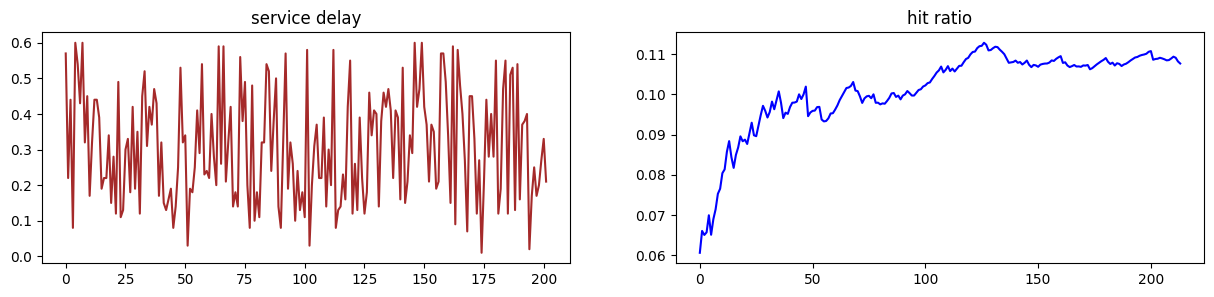

(1). hit_ratio: 0; service_delay: 0.327
(2). hit_ratio: 0.083; service_delay: 0.283
(3). hit_ratio: 0.095; service_delay: 0.282
(4). hit_ratio: 0.104; service_delay: 0.296
(5). hit_ratio: 0.1; service_delay: 0.303
(6). hit_ratio: 0.117; service_delay: 0.305
(7). hit_ratio: 0.137; service_delay: 0.31
(8). hit_ratio: 0.128; service_delay: 0.312
(9). hit_ratio: 0.125; service_delay: 0.316
(10). hit_ratio: 0.111; service_delay: 0.322
(11). hit_ratio: 0.108; service_delay: 0.324
(12). hit_ratio: 0.114; service_delay: 0.326
(13). hit_ratio: 0.118; service_delay: 0.328
(14). hit_ratio: 0.118; service_delay: 0.329
(15). hit_ratio: 0.11; service_delay: 0.329
(16). hit_ratio: 0.107; service_delay: 0.331
(17). hit_ratio: 0.107; service_delay: 0.33
(18). hit_ratio: 0.104; service_delay: 0.328
(19). hit_ratio: 0.103; service_delay: 0.33
(20). hit_ratio: 0.106; service_delay: 0.329
(21). hit_ratio: 0.107; service_delay: 0.329
(22). hit_ratio: 0.106; service_delay: 0.328
(23). hit_ratio: 0.105; servi

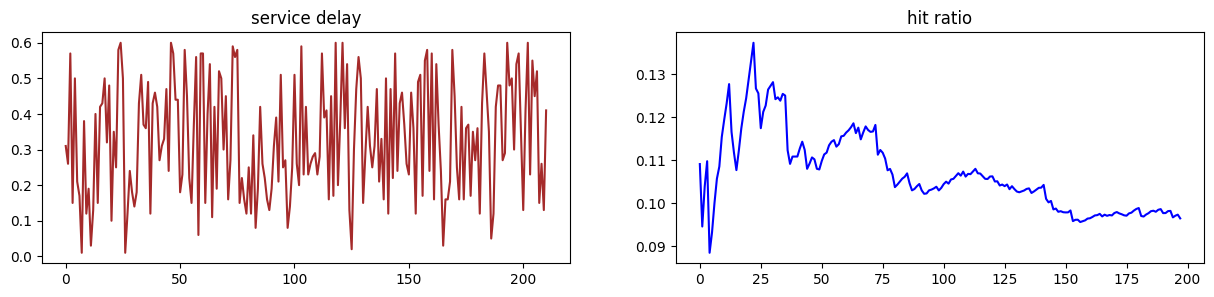

(1). hit_ratio: 0.429; service_delay: 0.17
(2). hit_ratio: 0.261; service_delay: 0.281
(3). hit_ratio: 0.191; service_delay: 0.283
(4). hit_ratio: 0.181; service_delay: 0.293
(5). hit_ratio: 0.129; service_delay: 0.311
(6). hit_ratio: 0.134; service_delay: 0.317
(7). hit_ratio: 0.125; service_delay: 0.313
(8). hit_ratio: 0.124; service_delay: 0.316
(9). hit_ratio: 0.121; service_delay: 0.315
(10). hit_ratio: 0.119; service_delay: 0.315
(11). hit_ratio: 0.116; service_delay: 0.322
(12). hit_ratio: 0.116; service_delay: 0.321
(13). hit_ratio: 0.113; service_delay: 0.325
(14). hit_ratio: 0.114; service_delay: 0.326
(15). hit_ratio: 0.113; service_delay: 0.326
(16). hit_ratio: 0.115; service_delay: 0.325
(17). hit_ratio: 0.109; service_delay: 0.327
(18). hit_ratio: 0.115; service_delay: 0.326
(19). hit_ratio: 0.114; service_delay: 0.325
(20). hit_ratio: 0.115; service_delay: 0.325
(21). hit_ratio: 0.115; service_delay: 0.325
(22). hit_ratio: 0.114; service_delay: 0.326
(23). hit_ratio: 0.1

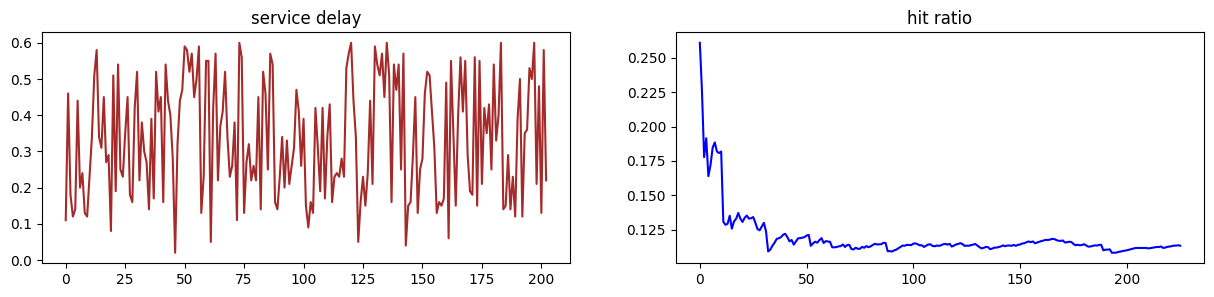

(1). hit_ratio: 0.167; service_delay: 0.268
(2). hit_ratio: 0.188; service_delay: 0.277
(3). hit_ratio: 0.188; service_delay: 0.283
(4). hit_ratio: 0.148; service_delay: 0.279
(5). hit_ratio: 0.133; service_delay: 0.292
(6). hit_ratio: 0.133; service_delay: 0.293
(7). hit_ratio: 0.131; service_delay: 0.306
(8). hit_ratio: 0.121; service_delay: 0.307
(9). hit_ratio: 0.135; service_delay: 0.312
(10). hit_ratio: 0.128; service_delay: 0.317
(11). hit_ratio: 0.126; service_delay: 0.317
(12). hit_ratio: 0.127; service_delay: 0.313
(13). hit_ratio: 0.138; service_delay: 0.31
(14). hit_ratio: 0.133; service_delay: 0.308
(15). hit_ratio: 0.131; service_delay: 0.308
(16). hit_ratio: 0.133; service_delay: 0.308
(17). hit_ratio: 0.133; service_delay: 0.309
(18). hit_ratio: 0.134; service_delay: 0.309
(19). hit_ratio: 0.132; service_delay: 0.31
(20). hit_ratio: 0.13; service_delay: 0.311
(21). hit_ratio: 0.131; service_delay: 0.312
(22). hit_ratio: 0.13; service_delay: 0.313
(23). hit_ratio: 0.129;

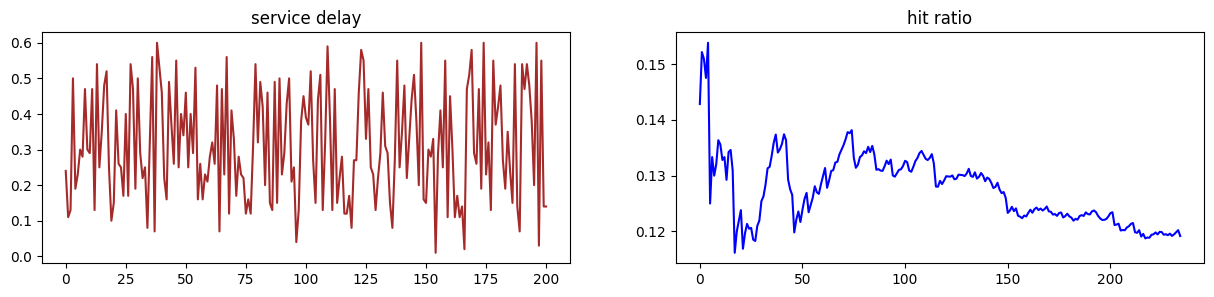

(1). hit_ratio: 0; service_delay: 0.4
(2). hit_ratio: 0.182; service_delay: 0.292
(3). hit_ratio: 0.182; service_delay: 0.335
(4). hit_ratio: 0.087; service_delay: 0.343
(5). hit_ratio: 0.087; service_delay: 0.353
(6). hit_ratio: 0.061; service_delay: 0.345
(7). hit_ratio: 0.07; service_delay: 0.329
(8). hit_ratio: 0.084; service_delay: 0.328
(9). hit_ratio: 0.086; service_delay: 0.327
(10). hit_ratio: 0.081; service_delay: 0.331
(11). hit_ratio: 0.081; service_delay: 0.332
(12). hit_ratio: 0.094; service_delay: 0.329
(13). hit_ratio: 0.094; service_delay: 0.333
(14). hit_ratio: 0.094; service_delay: 0.332
(15). hit_ratio: 0.101; service_delay: 0.329
(16). hit_ratio: 0.101; service_delay: 0.33
(17). hit_ratio: 0.098; service_delay: 0.33
(18). hit_ratio: 0.098; service_delay: 0.332
(19). hit_ratio: 0.094; service_delay: 0.331
(20). hit_ratio: 0.092; service_delay: 0.333
(21). hit_ratio: 0.095; service_delay: 0.334
(22). hit_ratio: 0.094; service_delay: 0.334
(23). hit_ratio: 0.096; serv

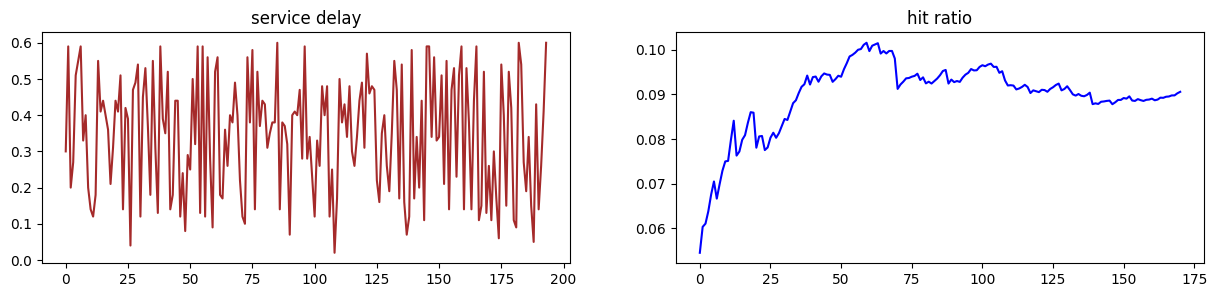

(1). hit_ratio: 0; service_delay: 0.41
(2). hit_ratio: 0; service_delay: 0.302
(3). hit_ratio: 0.143; service_delay: 0.312
(4). hit_ratio: 0.203; service_delay: 0.308
(5). hit_ratio: 0.176; service_delay: 0.307
(6). hit_ratio: 0.121; service_delay: 0.321
(7). hit_ratio: 0.127; service_delay: 0.324
(8). hit_ratio: 0.137; service_delay: 0.32
(9). hit_ratio: 0.131; service_delay: 0.324
(10). hit_ratio: 0.134; service_delay: 0.32
(11). hit_ratio: 0.132; service_delay: 0.316
(12). hit_ratio: 0.129; service_delay: 0.316
(13). hit_ratio: 0.13; service_delay: 0.318
(14). hit_ratio: 0.122; service_delay: 0.319
(15). hit_ratio: 0.117; service_delay: 0.319
(16). hit_ratio: 0.118; service_delay: 0.321
(17). hit_ratio: 0.115; service_delay: 0.321
(18). hit_ratio: 0.114; service_delay: 0.322
(19). hit_ratio: 0.115; service_delay: 0.323
(20). hit_ratio: 0.115; service_delay: 0.325
(21). hit_ratio: 0.113; service_delay: 0.325
(22). hit_ratio: 0.114; service_delay: 0.325
(23). hit_ratio: 0.111; service

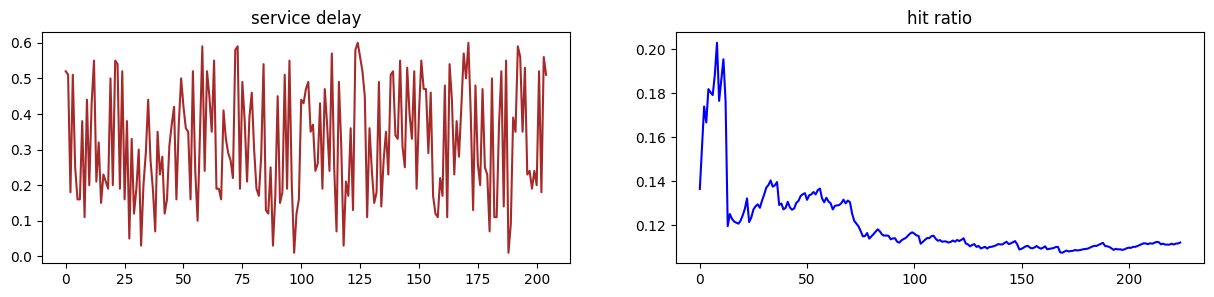

(1). hit_ratio: 0; service_delay: 0.335
(2). hit_ratio: 0.2; service_delay: 0.291
(3). hit_ratio: 0.119; service_delay: 0.3
(4). hit_ratio: 0.113; service_delay: 0.302
(5). hit_ratio: 0.117; service_delay: 0.308
(6). hit_ratio: 0.103; service_delay: 0.303
(7). hit_ratio: 0.105; service_delay: 0.308
(8). hit_ratio: 0.116; service_delay: 0.3
(9). hit_ratio: 0.114; service_delay: 0.307
(10). hit_ratio: 0.105; service_delay: 0.312
(11). hit_ratio: 0.106; service_delay: 0.316
(12). hit_ratio: 0.102; service_delay: 0.317
(13). hit_ratio: 0.102; service_delay: 0.319
(14). hit_ratio: 0.1; service_delay: 0.323
(15). hit_ratio: 0.101; service_delay: 0.323
(16). hit_ratio: 0.101; service_delay: 0.324
(17). hit_ratio: 0.099; service_delay: 0.325
(18). hit_ratio: 0.102; service_delay: 0.325
(19). hit_ratio: 0.102; service_delay: 0.322
(20). hit_ratio: 0.1; service_delay: 0.323
(21). hit_ratio: 0.101; service_delay: 0.324
(22). hit_ratio: 0.097; service_delay: 0.323
(23). hit_ratio: 0.098; service_d

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(actor,self).__init__()
        self.fc1 = nn.Linear(state_dim, 2000)
        self.fc2 = nn.Linear(2000,action_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.to(device)
        x = self.relu(self.fc1(x))
        x = self.tanh(self.fc2(x))
        return x

class critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(critic,self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 2000)
        self.fc2 = nn.Linear(2000,1)
        self.relu = nn.ReLU()

    def forward(self, x, y):
        # print(x.shape)
        # print(len(y.shape))
        if len(y.shape) == 2:
            y = torch.unsqueeze(y, dim=1)
        x = torch.cat((x,y), 2)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

from collections import deque
import random
import numpy as np

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity

    def put(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

import torch.optim as optim
import torch.nn.functional as F
class DDPG(object):
    def __init__(self, state_dim, action_dim, gamma = 0.99, tau = 0.001, lr_actor = 0.0001, lr_critic = 0.001, capacity = 500000, batch_size = 256):
        # 使用doublenet策略
        self.Actor = actor(state_dim, action_dim)
        self.Actor_Target = actor(state_dim, action_dim)
        self.Actor_Target.load_state_dict(self.Actor.state_dict())

        self.Critic = critic(state_dim, action_dim)
        self.Critic_Target = critic(state_dim, action_dim)
        self.Critic_Target.load_state_dict(self.Critic.state_dict())

        self.gamma = gamma
        self.tau = tau
        self.optimizer_actor = optim.Adam(self.Actor.parameters(), lr_actor)
        self.optimizer_critic = optim.Adam(self.Critic.parameters(), lr_critic)
        self.memory = ReplayBuffer(capacity = capacity)
        self.batch_size = batch_size
        self.max_episode = 25
        self.max_step = 7500

    def select_action(self, state, episode, action_space):
        if random.random() <= episode / self.max_episode + 0.2:
            action = self.Actor(state).cpu().detach().numpy()[0]
        else:
            action = action_space.sample()
        return action

    def update(self):

        if len(self.memory) < self.batch_size:
            return

        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        # 主网络网络更新
        ## 更新Critic：
        ### 计算损失
        Q_target = reward.unsqueeze(-1) + self.gamma * self.Critic_Target(next_state, self.Actor_Target(next_state))
        Q_current = self.Critic(state, action)
        Critic_Loss = F.mse_loss(Q_current, Q_target.detach())
        ### 更新参数
        self.optimizer_critic.zero_grad()
        Critic_Loss.backward()
        self.optimizer_critic.step()

        ## 更新Actor
        ### 计算损失
        Actor_Loss = - self.Critic(state, self.Actor(state)).mean()
        ### 更新参数
        self.optimizer_actor.zero_grad()
        Actor_Loss.backward()
        self.optimizer_actor.step()

        # 更新目标网络
        self.softupdate(self.Actor, self.Actor_Target)
        self.softupdate(self.Critic, self.Critic_Target)

    def softupdate(self, local_model, target_model):
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1-self.tau) * target_param.data)

# 算法测试，cache环境
import numpy as np
import torch

# 创建环境
env = Edge_Caching_Vehicular_Networks()
env.algorithm = 'AFRL'
env.show = False
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# 设置智能体
agent = DDPG(state_dim, action_dim)
agent.Actor = agent.Actor.to(device)
agent.Actor_Target = agent.Actor_Target.to(device)
agent.Critic = agent.Critic.to(device)
agent.Critic_Target = agent.Critic_Target.to(device)

# 训练智能体
for i_episode in range(agent.max_episode):
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)
    for t in range(agent.max_step):
        action = agent.select_action(state, i_episode, env.action_space)
        next_state, reward, done, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        agent.memory.put(state, action, reward, next_state, done)
        agent.update()
        if (t+1)%200 == 0:
            print(F'({(t+1)//200}). hit_ratio: {round(env.hit_ratio,3)}; service_delay: {round(sum(env.service_delay) / max(1, len(env.service_delay)),3)}')
        state = next_state
        if done:
            break

    print(f'Episode {i_episode + 1}: Finished after {t + 1} timesteps')
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,3))
    axs[0].plot(range(len(env.service_delay[::10])),env.service_delay[::10],color = 'brown')
    axs[0].set_title('service delay')
    axs[1].plot(range(len(env.hit_ratio_LST) - 5),env.hit_ratio_LST[5:],color='blue')
    axs[1].set_title('hit ratio')
    plt.show()

In [ ]:
import pickle

with open('/content/drive/MyDrive/rst2/agent1_30ep_7500_step_cr_tar.pickle', 'wb') as f:
    pickle.dump(agent.Critic_Target,f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5下降